In [79]:
from raw_python.Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from raw_python.BaggingSA import BaggingSA
from typing import Literal, Tuple
from raw_python.Bagging import predict
import sklearn
from raw_python.plots_manager import *
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from tabulate import tabulate


# PARAMS

+---------+------+-------+-------+----------+--------------+---------------+
| dataset | beta | gamma | delta | accuracy | fitness_norm | spearman_corr |
+---------+------+-------+-------+----------+--------------+---------------+
| digits  | 0.25 | 0.25  | 0.01  |  0.944   |    0.695     |     0.131     |
+---------+------+-------+-------+----------+--------------+---------------+


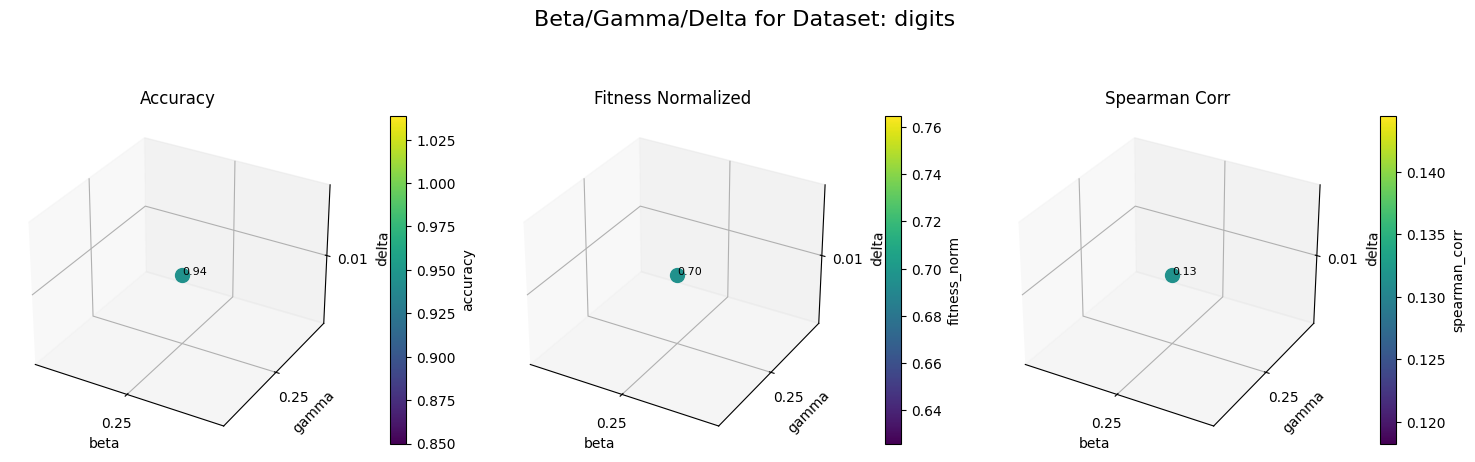

In [80]:
greeks = ['beta', 'gamma', 'delta']

files = glob.glob('./../res/params_*.csv')
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df['fitness_norm'] = (df['fitness'] + df['epsilon']) / (df['beta'] + df['gamma'] + df['epsilon'])

grouped = df.groupby(['dataset'] + greeks).agg({
    'accuracy': 'mean',
    'fitness_norm': 'mean',
    'spearman_corr': 'mean'
}).reset_index()

grouped_corr = df[df['spearman_p'] < 0.05].groupby(['dataset'] + greeks).agg({
    'accuracy': 'mean',
    'fitness_norm': 'mean',
    'spearman_corr': 'mean'
}).reset_index()


best_by_dataset = grouped.loc[grouped.groupby('dataset')['accuracy'].idxmax()]
tmp = best_by_dataset.copy().round(3)
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))


# 3D Scatter Plot Function
def plot_metrics_3d_subplots(df, dataset, metrics, titles, themes):
    fig = plt.figure(figsize=(15, 5))  # Adjust figure size for subplots
    fig.suptitle(f"Beta/Gamma/Delta for Dataset: {dataset}", fontsize=16, x=0.5)
    for i, (metric, title, theme) in enumerate(zip(metrics, titles, themes), start=1):
        df_tmp = df[df['dataset'] == dataset]
        ax = fig.add_subplot(1, 3, i, projection='3d')  # Create a subplot for each metric
        sc = ax.scatter(df_tmp[greeks[0]], df_tmp[greeks[1]], df_tmp[greeks[2]], c=df_tmp[metric], cmap=theme, s=100)
        ax.set_xlabel(greeks[0])
        ax.set_ylabel(greeks[1])
        ax.set_zlabel(greeks[2])
        ax.set_title(title)
        
        ax.set_xticks(df_tmp[greeks[0]].unique())
        ax.set_yticks(df_tmp[greeks[1]].unique())
        ax.set_zticks(df_tmp[greeks[2]].unique())
        
        # Adjust colorbar position and size
        cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.1)  # Shrink and add padding
        cbar.set_label(metric)
        
        # Add numeric annotations
        for _, row in df_tmp.iterrows():
            ax.text(row[greeks[0]], row[greeks[1]], row[greeks[2]], f"{row[metric]:.2f}", fontsize=8, color='black')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()

datasets = grouped['dataset'].unique()

# Define metrics, titles, and themes for the subplots
metrics = ['accuracy', 'fitness_norm', 'spearman_corr']
titles = [
    'Accuracy',
    'Fitness Normalized',
    'Spearman Corr'
]
themes = ['viridis', 'viridis', 'viridis']

# Generate subplots for each dataset
for dataset in datasets:
    plot_metrics_3d_subplots(grouped, dataset, metrics, titles, themes)

In [81]:
# # Optionally average over replicates
# grouped = df.groupby(['theta', 'beta', 'gamma']).agg({
#     'accuracy': 'mean',
#     'fitness': 'mean',
#     'spearman_corr': 'mean'
# }).reset_index()

# # Define a function to plot 3D scatter
# def plot_3d_metric(data, metric, title):
#     fig = px.scatter_3d(
#         data, x='theta', y='beta', z='gamma',
#         color=metric, size_max=10,
#         title=title,
#         color_continuous_scale='Viridis',
#         labels={'theta': 'Theta', 'beta': 'Beta', 'gamma': 'Gamma'}
#     )
#     fig.update_traces(marker=dict(size=5))
#     fig.show()

# # Create interactive 3D plots
# plot_3d_metric(grouped, 'accuracy', 'Accuracy vs Theta/Beta/Gamma')
# plot_3d_metric(grouped, 'fitness', 'Fitness vs Theta/Beta/Gamma')
# plot_3d_metric(grouped, 'spearman_corr', 'Spearman Correlation vs Theta/Beta/Gamma')

# RESULT COMPARISON PLOTS  

In [82]:
def create_comparison_plot(df: pd.DataFrame) -> None:
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    plt.figure(figsize=(12, 4))
    
    X = df['nTrees'].unique()
    dataset_name = df['Dataset'].values[0]
    
    y_data=[
        ("BaggingAccuracy", "Bagging"),
        ("SAAccuracy", "Bagging SA")
    ]

    for df_name, plt_name in y_data:
        Y, Y_std = df[df_name], df[df_name + "_STD"]
        plt.plot(X, Y, marker='o', label=plt_name)
        plt.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.2)

    plt.title(f"Accuracy per trees amount for dataset: {dataset_name}")
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(X)
    plt.grid()
    
    plt.show()
    
    

In [83]:
from tabulate import tabulate


files = glob.glob('./../res/metrics_*.csv')
dfs = [pd.read_csv(f) for f in files]

for df in dfs:
    df_aggregated = df.groupby(['nTrees']).agg(
        Dataset=('Dataset', 'first'),
        nTrees=('nTrees', 'first'),
        
        Bagging=('BaggingAccuracy', 'mean'),
        BaggingSA=('SAAccuracy', 'mean'),

        Bagging_STD=('BaggingAccuracy','std'),
        BaggingSA_STD=('SAAccuracy','std'),
    ).reset_index(drop=True).dropna()
    
    tmp = df_aggregated.copy().round(3)
    print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))
    create_comparison_plot(df_aggregated)
    print()
    
    

+---------+--------+---------+-----------+-------------+---------------+
| Dataset | nTrees | Bagging | BaggingSA | Bagging_STD | BaggingSA_STD |
+---------+--------+---------+-----------+-------------+---------------+
+---------+--------+---------+-----------+-------------+---------------+


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x400 with 0 Axes>